In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from graphwave import graphwave
from graphwave.utils import utils

In [2]:
path_to_files = "../datasets/MUTAG/"

In [3]:
G = nx.read_edgelist(path_to_files + "MUTAG_A.txt", delimiter=',', nodetype=int, encoding="utf-8")
nodes = pd.read_csv(path_to_files + "MUTAG_graph_indicator.txt", header=None)
nodes.index += 1
nodes = nodes.reset_index().rename(columns={"index":"node", 0:"component"})



In [4]:
nodes.head()

,node,component
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [5]:
subgraphs = nodes.groupby('component')['node'].apply(list) \
    .map(lambda x: G.subgraph(x)).to_dict()

In [6]:
subgraphs

{1: <networkx.classes.graphviews.SubGraph at 0x10b8686d8>,
 2: <networkx.classes.graphviews.SubGraph at 0x10b868b38>,
 3: <networkx.classes.graphviews.SubGraph at 0x10b868c18>,
 4: <networkx.classes.graphviews.SubGraph at 0x10b868d68>,
 5: <networkx.classes.graphviews.SubGraph at 0x10b868160>,
 6: <networkx.classes.graphviews.SubGraph at 0x10b8681d0>,
 7: <networkx.classes.graphviews.SubGraph at 0x10b868dd8>,
 8: <networkx.classes.graphviews.SubGraph at 0x10b868eb8>,
 9: <networkx.classes.graphviews.SubGraph at 0x10b868f98>,
 10: <networkx.classes.graphviews.SubGraph at 0x10bb670b8>,
 11: <networkx.classes.graphviews.SubGraph at 0x10bb67198>,
 12: <networkx.classes.graphviews.SubGraph at 0x10bb67278>,
 13: <networkx.classes.graphviews.SubGraph at 0x10bb67358>,
 14: <networkx.classes.graphviews.SubGraph at 0x10bb67438>,
 15: <networkx.classes.graphviews.SubGraph at 0x10bb67518>,
 16: <networkx.classes.graphviews.SubGraph at 0x10bb675f8>,
 17: <networkx.classes.graphviews.SubGraph at 0x1

In [7]:
subgraphs[1].edges()

EdgeView([(2, 1), (2, 3), (1, 6), (3, 4), (4, 5), (4, 10), (5, 6), (5, 7), (7, 8), (8, 9), (9, 10), (9, 14), (10, 11), (11, 12), (12, 13), (13, 14), (13, 15), (15, 16), (15, 17)])

In [8]:
subgraphs[2].edges()

EdgeView([(19, 18), (19, 20), (18, 27), (20, 21), (20, 25), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (26, 28), (28, 29), (28, 30)])

In [9]:
subgraphs[2].nodes()

NodeView((19, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30))

In [10]:
subgraphs[1].nodes()

NodeView((2, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17))

In [11]:
node_labels = pd.read_csv(path_to_files + "MUTAG_node_labels.txt", header=None)
node_labels.index += 1
node_labels = dict(node_labels[0])
nodes['node_label'] =  nodes.node.map(node_labels)

In [12]:
component_labels = pd.read_csv(path_to_files + "MUTAG_graph_labels.txt", header=None)
component_labels.index += 1
component_labels = dict(component_labels[0])
nodes['component_label'] = nodes.component.map(component_labels)

In [13]:
chi, heat_print, taus = graphwave.graphwave_alg(subgraphs[1], np.linspace(0,100,25), taus='auto', verbose=True)

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

nb_clust = 6
trans_data_all = []
n_components = 4
keys = []
nodes_list = []

for key, graph in subgraphs.items():
    # Heat diffusion characteristics over 25 * 4 (not sure where 4 comes from) time-steps
    chi, heat_print, taus = graphwave.graphwave_alg(graph, np.linspace(0,100,25), taus='auto', verbose=True)
    if len(graph.nodes) < n_components:
        print("Omitting graph " + key + " with node count: "+ str(len(graph.nodes)) +" < " + n_components)
    else:
        # Reduce dimensionality to num_nodes x n_components 
        pca = PCA(n_components)
        # Scale to accentuate differences
        trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
        trans_data_all = trans_data_all + trans_data.tolist()
        l = [key] * len(graph.nodes)
        keys = keys + l
        nodes_list = nodes_list + list(graph.nodes())

km = KMeans(n_clusters=nb_clust)
km.fit(trans_data_all)
labels_pred=km.labels_

## What is happening?
For each subgraph (connected component) in the graph, we apply GraphWave - a method to learn structural signatures by applying heat to a node over time and recording how other nodes react. We end up with a time-series for each node in the subgraph.

Then, we scale the results to [-1, 1] and reduce the dimensionality of the time-series results using PCA. This allows us to project each node in *n_components*-dimensional space (we chose 4).

After we get all the nodes into 4d space, we can assign labels via KMeans clustering.

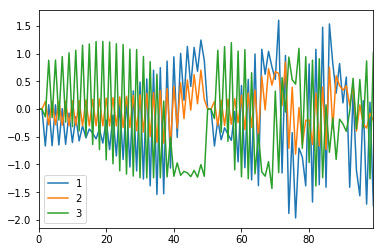

In [15]:
# 16 nodes expressed along 4 dimensions
np.array(trans_data.tolist()).shape
# Every node represented by 4 dimensions
np.array(trans_data_all).shape 
# Results of clustering all 3371 nodes (represented in 4 learned dimensions)
pd.Series(labels_pred).value_counts().sort_index()

pca = PCA(n_components)
# Scale to accentuate differences
trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))

import matplotlib.pyplot
%matplotlib inline
pd.DataFrame(StandardScaler().fit_transform(chi)).T[[1,2,3]].plot()

In [16]:
len(subgraphs[1].nodes)

17

In [17]:
labels_pred[0:18]

array([5, 5, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 3, 2, 2, 0], dtype=int32)

In [18]:
nodes['graphwave_label'] = labels_pred

In [19]:
nodes['node_label'] = nodes.node_label.map({0: "C",
                                            1: "N",
                                            2: "O",
                                            3: "F",
                                            4: "I",
                                            5: "Cl",
                                            6: "Br"})

In [20]:
nodes.tail()

,node,component,node_label,component_label,graphwave_label
3366,3367,188,C,-1,1
3367,3368,188,C,-1,0
3368,3369,188,N,-1,3
3369,3370,188,O,-1,2
3370,3371,188,O,-1,2


## Random Walks
Using the provided *node_label*s, along with the learned structural signature GraphWave labels, we can express the subgraphs to a language model.

In [21]:
e = pd.read_csv(path_to_files+"MUTAG_edge_labels.txt", header=None)

In [22]:
edge_words = e[0].apply(lambda x: "e"+str(x))

In [23]:
edges = pd.read_csv(path_to_files + "MUTAG_A.txt", header=None)

In [24]:
edge_words.index += 1
edges.index += 1
edges['label'] = edge_words

In [25]:
nodes['label'] = nodes.node_label + " " + nodes.graphwave_label.astype(str)
nodes_indexed = nodes.set_index('node')['label'].T.to_dict()

In [27]:
for start, end, edge in G.edges(data=True):
    edge['weight'] = 1

In [41]:
from n2v import node2vec

n2vG = node2vec.Graph(nx_G=G, is_directed=False, p=1, q=.7)
n2vG.preprocess_transition_probs()
num_walks = 20
walk_length  =30
walks = n2vG.simulate_walks(num_walks, walk_length)
len(walks)

Walk iteration:
('1', '/', '20')
('2', '/', '20')
('3', '/', '20')
('4', '/', '20')
('5', '/', '20')
('6', '/', '20')
('7', '/', '20')
('8', '/', '20')
('9', '/', '20')
('10', '/', '20')
('11', '/', '20')
('12', '/', '20')
('13', '/', '20')
('14', '/', '20')
('15', '/', '20')
('16', '/', '20')
('17', '/', '20')
('18', '/', '20')
('19', '/', '20')
('20', '/', '20')


67420

In [44]:
# edges = edges.to_dict()
edges = edges.set_index([0,1]).to_dict()['label']
# [(2,1)]

In [45]:
processed_walks = []
for walk in walks:
    rw = ""
    start_node = walk[0]
    rw += nodes_indexed[start_node] + " ";
    for step in range(len(walk) - 1):
        start_node = walk[step]
        end_node = walk[step + 1]
        edge_taken = edges[(start_node, end_node)]
        rw += str(edge_taken) + " " + nodes_indexed[end_node] + " "
        step + 1
    processed_walks += [rw]



In [47]:
len(processed_walks)

67420

In [50]:
len(processed_walks) / 20

3371.0

In [54]:
walks[1:20]

[[3353,
  3351,
  3352,
  3347,
  3352,
  3347,
  3348,
  3349,
  3350,
  3351,
  3352,
  3347,
  3352,
  3351,
  3350,
  3349,
  3348,
  3347,
  3348,
  3338,
  3337,
  3336,
  3337,
  3338,
  3339,
  3341,
  3342,
  3341,
  3346,
  3345],
 [436,
  437,
  436,
  435,
  426,
  425,
  424,
  429,
  424,
  425,
  424,
  429,
  428,
  429,
  430,
  429,
  424,
  429,
  430,
  431,
  430,
  429,
  428,
  427,
  428,
  429,
  430,
  429,
  428,
  429],
 [2356,
  2354,
  2353,
  2354,
  2356,
  2354,
  2355,
  2354,
  2353,
  2348,
  2349,
  2350,
  2349,
  2350,
  2349,
  2350,
  2351,
  2357,
  2351,
  2352,
  2351,
  2352,
  2351,
  2350,
  2360,
  2361,
  2360,
  2361,
  2360,
  2350],
 [1324,
  1323,
  1324,
  1319,
  1324,
  1323,
  1325,
  1326,
  1327,
  1328,
  1327,
  1326,
  1327,
  1326,
  1327,
  1328,
  1329,
  1331,
  1329,
  1330,
  1325,
  1326,
  1327,
  1326,
  1327,
  1326,
  1325,
  1330,
  1325,
  1326],
 [1941,
  1928,
  1929,
  1930,
  1939,
  1938,
  1933,
  1934,
  

In [46]:
walk = walks[0]

In [507]:
rw = ""
start_node = walk[0]
rw += nodes_indexed[start_node] + " ";
for step in range(len(walk) - 1):
    start_node = walk[step]
    end_node = walk[step + 1]
    edge_taken = edges[(start_node, end_node)]
    rw += str(edge_taken) + " " + nodes_indexed[end_node] + " "
    step + 1
    
